author: Łukasz Szymczyk (szymczyklp@gmail.com) <br>
date: 2022-03-06 <br>
version: 2.1

## Packages

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import re
import warnings
from IPython.display import clear_output

from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.formula.api import ols

## Data In

In [2]:
path = r'D:/MSI_BACKUP/SCIENCE/PhD/ART/4_liq_risk/data/'

In [3]:
# data set 
file = r'monthly returns for 117 funds EXCESS RETURNS 25SEP2021.xlsx'
data_excel = pd.ExcelFile(path + 'in/' + file)
returns_funds = data_excel.parse('7 FACTOR MODEL EXCESS RETURNS') 

In [4]:
# benchmark
spx = pd.read_csv(path + 'in/' + '^spx_m.csv', sep = ',', decimal = '.')

In [5]:
# risk free 
file = 'AQR_RF.xlsx'
data_excel = pd.ExcelFile(path + 'in/' + file)
rf = data_excel.parse('RF', usecols = 'A:B') 

## RegEx

In [6]:
pattern_period = re.compile(r'^(Monthly Return) ([0-9]{4}-[0-9]{2}) (Base Currency)$')

## Function

In [7]:
def period_extraction(kol_in,pattern):
    '''
    Extractin period from data description
    '''
    try:
        re.search(pattern,kol_in).group(0)
        kol_out = re.search(pattern,kol_in).group(2)
        kol_out = pd.to_datetime(kol_out)
        kol_out = kol_out + relativedelta(months=1, days=-1) 
        return kol_out
    except AttributeError:
        return None

## Hyperparameters

In [8]:
window = 36
date_start = pd.to_datetime('2011-06-30')

## Data Prep

In [9]:
returns_funds = returns_funds.rename(columns={'Unnamed: 0': 'Period'})
returns_funds['Period'] = np.vectorize(period_extraction)(returns_funds['Period'],pattern_period)
returns_funds = returns_funds.set_index('Period')
returns_funds = returns_funds.rename(columns={'HML Devil': 'HML_Devil'
                                    , 'INT RATES' : 'INT_RATES'
                                    , 'CREDIT SPREADS' : 'CREDIT_SPREADS'
                                    , 'EM EQUITY' : 'EM_EQUITY'
                                   })


In [10]:
#risk free
rf = pd.DataFrame(rf)
rf = rf.rename(columns={'DATE': 'Period'})
rf['Period'] = pd.to_datetime(rf['Period'])
rf = rf.set_index('Period')
rf = rf.loc[rf.index >= date_start + relativedelta(months=-3)]

In [11]:
# Benchmark to Lagged Effects and CAMP models
spx['returns0'] = spx['Zamkniecie'].pct_change()
spx = pd.DataFrame(spx)
spx = spx.rename(columns={'Data': 'Period'})
spx['Period'] = pd.to_datetime(spx['Period'])
spx = spx.set_index('Period')
spx = spx.loc[spx.index >= date_start + relativedelta(months=-3)]

In [12]:
spx = spx.join(rf)
spx['returns0'] = spx['returns0'] - spx['Risk Free Rate']
spx['returns1'] = spx['returns0'].shift(periods=1)
spx['returns2'] = spx['returns0'].shift(periods=2)
spx['returns3'] = spx['returns0'].shift(periods=3)
spx = spx.loc[spx.index >= date_start]
spx = spx.loc[:,('returns0','returns1','returns2','returns3')]
spx.head()

,returns0,returns1,returns2,returns3
Period,,,,
2011-06-30,-0.018308,-0.013534,0.028420,-0.001172
2011-07-31,-0.021499,-0.018308,-0.013534,0.028420
2011-08-31,-0.056874,-0.021499,-0.018308,-0.013534
2011-09-30,-0.071779,-0.056874,-0.021499,-0.018308
2011-10-31,0.107706,-0.071779,-0.056874,-0.021499


## EQ 1 - AR(1)

In [13]:
dataset = returns_funds.drop(['MKT', 'SML', 'HML_Devil', 'MOM','INT_RATES','CREDIT_SPREADS','EM_EQUITY']
                                             , axis = 1)

In [14]:
dataset.head()

,_NT01,ABHIX,AGDAX,AHITX,AIOAX,AMHYX,ANHIX,ATPYX,AYBIX,BJBHX,...,TPHAX,TRHYX,TYHYX,USHYX,VHYLX,VWEHX,WAHYX,WRHIX,WTLTX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2011-06-30,-0.011302,-0.011967,-0.009093,-0.008334,-0.011367,-0.012643,-0.007371,-0.001778,-0.012266,-0.013570,...,-0.013990,-0.012673,-0.015485,-0.014003,-0.010521,-0.009686,-0.012385,-0.007111,-0.002888,-0.000050
2011-07-31,0.011355,0.010672,0.009244,0.006159,0.017558,0.010730,0.013380,0.011676,0.018225,0.005068,...,0.015078,0.010290,-0.011008,0.007241,0.007912,0.014547,0.010296,0.010717,0.015888,-0.002049
2011-08-31,-0.046497,-0.044790,-0.039936,-0.043742,-0.037068,-0.050412,-0.029770,-0.013694,-0.045240,-0.053058,...,-0.039403,-0.047126,-0.057748,-0.045717,-0.043390,-0.032013,-0.048892,-0.037955,-0.020632,-0.007126
2011-09-30,-0.035415,-0.035001,-0.043179,-0.036799,-0.023653,-0.030962,-0.022568,-0.007545,-0.029017,-0.046560,...,-0.020689,-0.034515,-0.063581,-0.033476,-0.023336,-0.019130,-0.031296,-0.018329,-0.010421,0.000997
2011-10-31,0.059616,0.066727,0.055722,0.056952,0.057142,0.058278,0.044970,0.023733,0.055477,0.059531,...,0.045908,0.059684,0.076901,0.042605,0.051950,0.053842,0.036600,0.044477,0.036441,0.003935


In [15]:
# empty tables to store the results of estimation

funds_AR_const = dataset.iloc[0:-window,:]
funds_AR_const = funds_AR_const.truncate(after = 0)
funds_AR_betas = funds_AR_const.truncate(after = 0)
funds_AR_const_pvalue = funds_AR_const.truncate(after = 0)
funds_AR_betas_pvalue = funds_AR_const.truncate(after = 0)

In [16]:
%%time

# estimation loop

b = 0
B = len(dataset.columns) -1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in dataset.columns:
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))
        
        for j in range(len(dataset) - window -1):
            last_window_period = dataset.index[j + window + 1]
            
            if not (pd.isna(dataset.loc[:,col_name].iloc[j])) and not(pd.isna(dataset.loc[:,col_name].iloc[j + window +1])):
                simulated_data = dataset.loc[:,col_name].iloc[j:(j+window+1)]
                mod = ARMA(simulated_data, order=(1,0))
                result = mod.fit()
                funds_AR_const.loc[last_window_period,col_name] = result.params[0]
                funds_AR_betas.loc[last_window_period,col_name] = result.params[1]
                funds_AR_const_pvalue.loc[last_window_period,col_name] = result.pvalues[0]
                funds_AR_betas_pvalue.loc[last_window_period,col_name] = result.pvalues[1]              
            else:
                funds_AR_const.loc[last_window_period,col_name] = float('NaN')
                funds_AR_betas.loc[last_window_period,col_name] = float('NaN')
                funds_AR_const_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_AR_betas_pvalue.loc[last_window_period,col_name] = float('NaN')
                
        b = b+1


ZEOIX :     116 / 116
Wall time: 5min 21s


## EQ 2 - CAMP

In [17]:
benchmark = pd.DataFrame(spx['returns0'])
#benchmark.plot()
dataset = benchmark.join(returns_funds.drop(['MKT', 'SML', 'HML_Devil', 'MOM','INT_RATES','CREDIT_SPREADS','EM_EQUITY']
                                             , axis = 1))

In [18]:
dataset.head()

,returns0,_NT01,ABHIX,AGDAX,AHITX,AIOAX,AMHYX,ANHIX,ATPYX,AYBIX,...,TPHAX,TRHYX,TYHYX,USHYX,VHYLX,VWEHX,WAHYX,WRHIX,WTLTX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2011-06-30,-0.018308,-0.011302,-0.011967,-0.009093,-0.008334,-0.011367,-0.012643,-0.007371,-0.001778,-0.012266,...,-0.013990,-0.012673,-0.015485,-0.014003,-0.010521,-0.009686,-0.012385,-0.007111,-0.002888,-0.000050
2011-07-31,-0.021499,0.011355,0.010672,0.009244,0.006159,0.017558,0.010730,0.013380,0.011676,0.018225,...,0.015078,0.010290,-0.011008,0.007241,0.007912,0.014547,0.010296,0.010717,0.015888,-0.002049
2011-08-31,-0.056874,-0.046497,-0.044790,-0.039936,-0.043742,-0.037068,-0.050412,-0.029770,-0.013694,-0.045240,...,-0.039403,-0.047126,-0.057748,-0.045717,-0.043390,-0.032013,-0.048892,-0.037955,-0.020632,-0.007126
2011-09-30,-0.071779,-0.035415,-0.035001,-0.043179,-0.036799,-0.023653,-0.030962,-0.022568,-0.007545,-0.029017,...,-0.020689,-0.034515,-0.063581,-0.033476,-0.023336,-0.019130,-0.031296,-0.018329,-0.010421,0.000997
2011-10-31,0.107706,0.059616,0.066727,0.055722,0.056952,0.057142,0.058278,0.044970,0.023733,0.055477,...,0.045908,0.059684,0.076901,0.042605,0.051950,0.053842,0.036600,0.044477,0.036441,0.003935


In [19]:
# empty tables to store the results of estimation

funds_CAMP_const = dataset.iloc[0:-window,4:]
funds_CAMP_const = funds_CAMP_const.truncate(after = 0)
funds_CAMP_betas = funds_CAMP_const.truncate(after = 0)
funds_CAMP_const_pvalue = funds_CAMP_const.truncate(after = 0)
funds_CAMP_betas_pvalue = funds_CAMP_const.truncate(after = 0)

In [20]:
# estimation loop
b = 0
B = len(dataset.columns) -1

In [21]:
%%time

b = 0
B = len(dataset.columns) -1 -1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in dataset.columns[1:]:
        
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))
        
        for j in range(len(dataset) - window):
            
            last_window_period = dataset.index[j + window]
            
            str_camp = str(col_name) + ' ~ returns0'
            
            if not (pd.isna(dataset.loc[:,col_name].iloc[j])) and not(pd.isna(dataset.loc[:,col_name].iloc[j + window])):
                
                simulated_data = dataset.loc[:,['returns0',col_name]].iloc[j:(j + window)]
                
                # CAMP
                mod = ols(str_camp, data = simulated_data)
                results = mod.fit()
                
                funds_CAMP_const.loc[last_window_period,col_name] = results.params[0]
                funds_CAMP_betas.loc[last_window_period,col_name] = results.params[1] 
                funds_CAMP_const_pvalue.loc[last_window_period,col_name] = results.pvalues[0]
                funds_CAMP_betas_pvalue.loc[last_window_period,col_name] = results.pvalues[1]
                
         
            else:
                funds_CAMP_const.loc[last_window_period,col_name] = float('NaN')
                funds_CAMP_betas.loc[last_window_period,col_name] = float('NaN')
                funds_CAMP_const_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_CAMP_betas_pvalue.loc[last_window_period,col_name] = float('NaN')

        b = b+1

ZEOIX :     116 / 116
Wall time: 52.9 s


## EQ 3 - Lagged Efects

In [22]:
benchmark = pd.DataFrame(spx)
#benchmark.plot()
dataset = benchmark.join(returns_funds.drop(['MKT', 'SML', 'HML_Devil', 'MOM','INT_RATES','CREDIT_SPREADS','EM_EQUITY']
                                             , axis = 1))

In [23]:
dataset.head()

,returns0,returns1,returns2,returns3,_NT01,ABHIX,AGDAX,AHITX,AIOAX,AMHYX,...,TPHAX,TRHYX,TYHYX,USHYX,VHYLX,VWEHX,WAHYX,WRHIX,WTLTX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2011-06-30,-0.018308,-0.013534,0.028420,-0.001172,-0.011302,-0.011967,-0.009093,-0.008334,-0.011367,-0.012643,...,-0.013990,-0.012673,-0.015485,-0.014003,-0.010521,-0.009686,-0.012385,-0.007111,-0.002888,-0.000050
2011-07-31,-0.021499,-0.018308,-0.013534,0.028420,0.011355,0.010672,0.009244,0.006159,0.017558,0.010730,...,0.015078,0.010290,-0.011008,0.007241,0.007912,0.014547,0.010296,0.010717,0.015888,-0.002049
2011-08-31,-0.056874,-0.021499,-0.018308,-0.013534,-0.046497,-0.044790,-0.039936,-0.043742,-0.037068,-0.050412,...,-0.039403,-0.047126,-0.057748,-0.045717,-0.043390,-0.032013,-0.048892,-0.037955,-0.020632,-0.007126
2011-09-30,-0.071779,-0.056874,-0.021499,-0.018308,-0.035415,-0.035001,-0.043179,-0.036799,-0.023653,-0.030962,...,-0.020689,-0.034515,-0.063581,-0.033476,-0.023336,-0.019130,-0.031296,-0.018329,-0.010421,0.000997
2011-10-31,0.107706,-0.071779,-0.056874,-0.021499,0.059616,0.066727,0.055722,0.056952,0.057142,0.058278,...,0.045908,0.059684,0.076901,0.042605,0.051950,0.053842,0.036600,0.044477,0.036441,0.003935


In [24]:
funds_LAGG_const = dataset.iloc[0:-window,4:]
funds_LAGG_const = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas0 = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas1 = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas2 = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas3 = funds_LAGG_const.truncate(after = 0)
funds_LAGG_const_pvalue = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas0_pvalue = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas1_pvalue = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas2_pvalue = funds_LAGG_const.truncate(after = 0)
funds_LAGG_betas3_pvalue = funds_LAGG_const.truncate(after = 0)

In [25]:
%%time

# estimation loop

b = 0
B = len(dataset.columns) - 4 -1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in dataset.columns[4:]:
        
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))
        
        for j in range(len(dataset) - window):
            
            last_window_period = dataset.index[j + window]
            

            str_lagg = str(col_name) + ' ~ returns0 + returns1 + returns2 + returns3'
            
            if not (pd.isna(dataset.loc[:,col_name].iloc[j])) and not(pd.isna(dataset.loc[:,col_name].iloc[j + window])):
                
                simulated_data = dataset.loc[:,['returns0','returns1','returns2','returns3',col_name]].iloc[j:(j + window)]
                

                mod = ols(str_lagg, data = simulated_data)
                results = mod.fit()
                
                funds_LAGG_const.loc[last_window_period,col_name] = results.params[0]
                funds_LAGG_betas0.loc[last_window_period,col_name] = results.params[1] 
                funds_LAGG_betas1.loc[last_window_period,col_name] = results.params[2] 
                funds_LAGG_betas2.loc[last_window_period,col_name] = results.params[3] 
                funds_LAGG_betas3.loc[last_window_period,col_name] = results.params[4] 
                funds_LAGG_const_pvalue.loc[last_window_period,col_name] = results.pvalues[0]
                funds_LAGG_betas0_pvalue.loc[last_window_period,col_name] = results.pvalues[1]
                funds_LAGG_betas1_pvalue.loc[last_window_period,col_name] = results.pvalues[2]
                funds_LAGG_betas2_pvalue.loc[last_window_period,col_name] = results.pvalues[3]
                funds_LAGG_betas3_pvalue.loc[last_window_period,col_name] = results.pvalues[4]
         
            else:

                funds_LAGG_const.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas0.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas1.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas2.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas3.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_const_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas0_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas1_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas2_pvalue.loc[last_window_period,col_name] = float('NaN')
                funds_LAGG_betas3_pvalue.loc[last_window_period,col_name] = float('NaN')

        b = b+1

ZEOIX :     116 / 116
Wall time: 1min 30s


## EQ 4 - VWEHX

In [26]:
references = pd.DataFrame(returns_funds.loc[:,'VWEHX'])
dataset = references.join(returns_funds.drop(['VWEHX', 'MKT', 'SML', 'HML_Devil', 'MOM','INT_RATES','CREDIT_SPREADS','EM_EQUITY']
                                             , axis = 1))

In [27]:
VWEHX_relation = pd.DataFrame({'Ticker' : [np.nan], 'Alpha' : [np.nan] , 'Alpha_pvalue' : [np.nan]
                               ,'Beta' : [np.nan], 'Beta_pvalue' : [np.nan]}).dropna()

In [28]:
%%time

# estimation loop

b = 0
B = len(dataset.columns) - 1 -1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in dataset.columns[1:]:
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))

        str_VWEHX = str(col_name) + ' ~ ' + references.columns[0]
        
        simulated_data = dataset.loc[:,['VWEHX',col_name]]
        mod = ols(str_VWEHX, data = simulated_data)
        results = mod.fit()
        
        VWEHX_relation = VWEHX_relation.append({'Ticker' : col_name
                                                , 'Alpha': results.params[0]
                                                , 'Alpha_pvalue' : results.pvalues[0]
                                                , 'Beta' : results.params[1]
                                                , 'Beta_pvalue' : results.pvalues[1]
                                               }, ignore_index=True)
                
        b = b+1

ZEOIX :     115 / 115
Wall time: 1.17 s


## EQ 5 - 7-factor model

In [29]:
RISK_FACTORS_relation = pd.DataFrame({'Ticker' : [np.nan], 'Rsquared' : [np.nan]
                                      ,'const' : [np.nan], 'const_pvalue' : [np.nan]
                                      ,'MKT' : [np.nan], 'MKT_pvalue' : [np.nan]
                                      ,'SML' : [np.nan], 'SML_pvalue' : [np.nan]
                                      ,'HML_Devil' : [np.nan], 'HML_Devil_pvalue' : [np.nan]
                                      ,'MOM' : [np.nan], 'MOM_pvalue' : [np.nan]
                                      ,'INT_RATES' : [np.nan], 'INT_RATES_pvalue' : [np.nan]
                                      ,'CREDIT_SPREADS' : [np.nan], 'CREDIT_SPREADS_pvalue' : [np.nan]
                                      ,'EM_EQUITY' : [np.nan], 'EM_EQUITY_pvalue' : [np.nan]
                                     }).dropna()

In [30]:
b = 0
B = len(returns_funds.columns) - 1 -7

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for col_name in returns_funds.columns[7:]:
        clear_output(wait = True)
        print(col_name + ' :     ' + str(b) + ' / ' + str(B))

        str_risk = str(col_name) + ' ~ ' + str(returns_funds.columns[0]) + ' + ' + str(returns_funds.columns[1]) + ' + ' \
        + str(returns_funds.columns[2]) + ' + ' + str(returns_funds.columns[3]) + ' + ' + str(returns_funds.columns[4]) + ' + ' \
        + str(returns_funds.columns[5]) + ' + ' + str(returns_funds.columns[6]) 
        
        simulated_data = returns_funds.iloc[:,:7].join(returns_funds.loc[:,[col_name]])
        mod = ols(str_risk, data = simulated_data)
        results = mod.fit()
        
        RISK_FACTORS_relation = RISK_FACTORS_relation.append({'Ticker' : col_name
                                                , 'Rsquared' : results.rsquared   
                                                , 'const': results.params[0]
                                                , 'const_pvalue' : results.pvalues[0]
                                                , 'MKT' : results.params[1]
                                                , 'MKT_pvalue' : results.pvalues[1]             
                                                , 'SML' : results.params[2]              
                                                , 'SML_pvalue' : results.pvalues[2]  
                                                , 'HML_Devil' : results.params[3]  
                                                , 'HML_Devil_pvalue' : results.pvalues[3]                
                                                , 'MOM' : results.params[4]                   
                                                , 'MOM_pvalue' : results.pvalues[4]               
                                                , 'INT_RATES' : results.params[5]     
                                                , 'INT_RATES_pvalue' : results.pvalues[5]               
                                                , 'CREDIT_SPREADS' : results.params[6]     
                                                , 'CREDIT_SPREADS_pvalue' : results.pvalues[6]               
                                                , 'EM_EQUITY' : results.params[7]                   
                                                , 'EM_EQUITY_pvalue' : results.pvalues[7] 
                                               }, ignore_index=True)
                
        b = b+1


ZEOIX :     116 / 116


## Data Out

In [33]:
funds_sheets = { 
                 # EQ 1
                 'AR_const': funds_AR_const, 
                 'AR_betas': funds_AR_betas, 
                 'AR_const_pvalue': funds_AR_const_pvalue,
                 'AR_betas_pvalue' : funds_AR_betas_pvalue,
                 # EQ 2
                 'CAMP_const': funds_CAMP_const, 
                 'CAMP_betas': funds_CAMP_betas, 
                 'CAMP_const_pvalue': funds_CAMP_const_pvalue,
                 'CAMP_betas_pvalue' : funds_CAMP_betas_pvalue,
                 # EQ 3
                 'LAGG_const': funds_LAGG_const, 
                 'LAGG_betas0': funds_LAGG_betas0,
                 'LAGG_betas1': funds_LAGG_betas1,
                 'LAGG_betas2': funds_LAGG_betas2,
                 'LAGG_betas3': funds_LAGG_betas3,
                 'LAGG_const_pvalue': funds_LAGG_const_pvalue,
                 'LAGG_betas0_pvalue' : funds_LAGG_betas0_pvalue,                 
                 'LAGG_betas1_pvalue' : funds_LAGG_betas1_pvalue, 
                 'LAGG_betas2_pvalue' : funds_LAGG_betas2_pvalue, 
                 'LAGG_betas3_pvalue' : funds_LAGG_betas3_pvalue,
                 # EQ 4
                 'VWEHX_relation' : VWEHX_relation,
                 # EQ 5
                 'RISK_FACTORS': RISK_FACTORS_relation
                }

writer = pd.ExcelWriter(path + 'out/funds_results.xlsx', engine='xlsxwriter')

for sheet_name in funds_sheets.keys():
    funds_sheets[sheet_name].to_excel(writer, sheet_name=sheet_name, index=True)

writer.save()

## Figures

In [35]:
dataset = returns_funds.drop(['MKT', 'SML', 'HML_Devil', 'MOM','INT_RATES','CREDIT_SPREADS','EM_EQUITY']
                                             , axis = 1)

In [68]:
sns.set_theme()
plt.figure(figsize=(50,9))
sns.set()

<Figure size 3600x648 with 0 Axes>

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# funds')

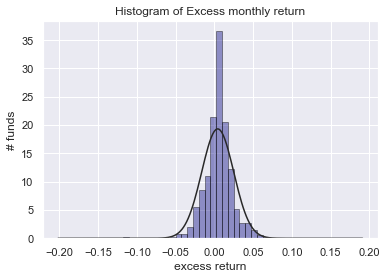

In [70]:
# seaborn histogram
sns.distplot(dataset
             #, hist=True
             , fit=norm
             , kde=False
             #, bins=30
             , color = 'navy'
             , hist_kws={'edgecolor':'black'}
             
            )
# Add labels
plt.title('Histogram of Excess monthly return')
plt.xlabel('excess return')
plt.ylabel('# funds')

In [77]:
funds_AR_betas

,_NT01,ABHIX,AGDAX,AHITX,AIOAX,AMHYX,ANHIX,ATPYX,AYBIX,BJBHX,...,TPHAX,TRHYX,TYHYX,USHYX,VHYLX,VWEHX,WAHYX,WRHIX,WTLTX,ZEOIX
Period,,,,,,,,,,,,,,,,,,,,,
2014-07-31,-0.120180,-0.212625,-0.101032,-0.135069,-0.259929,-0.111591,-0.158676,-0.240304,-0.221022,-0.089010,...,-0.130002,-0.166143,-0.046234,0.009568,-0.133506,-0.232789,0.045805,-0.060583,-0.231817,0.119158
2014-08-31,-0.119583,-0.206879,-0.097960,-0.140085,-0.245861,-0.109570,-0.152090,-0.225163,-0.205698,-0.093633,...,-0.119115,-0.165823,-0.070510,0.005228,-0.133375,-0.220074,0.046262,-0.049043,-0.217617,0.095635
2014-09-30,-0.143688,-0.242923,-0.112079,-0.174392,-0.255974,-0.129846,-0.153983,-0.231557,-0.208282,-0.128772,...,-0.109252,-0.196378,-0.150676,0.002114,-0.175219,-0.234312,0.081099,-0.055569,-0.200412,-0.080282
2014-10-31,-0.456254,-0.521272,-0.413121,-0.479568,-0.456005,-0.391041,-0.357449,-0.377137,-0.547811,-0.575218,...,-0.314840,-0.499372,-0.550734,-0.368260,-0.431698,-0.407697,-0.224940,-0.353599,-0.335905,-0.203019
2014-11-30,-0.240039,-0.396129,-0.177404,-0.276226,-0.409020,-0.237609,-0.216325,-0.354069,-0.382302,-0.262856,...,-0.190699,-0.326451,-0.241673,-0.139620,-0.335651,-0.361881,-0.020907,-0.163571,-0.350015,-0.189002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,0.009154,0.006550,0.073458,0.059314,-0.007500,0.065074,0.090512,0.090337,0.006293,0.028971,...,0.056776,-0.011940,0.071703,0.026237,0.026611,-0.056953,-0.004877,0.125796,-0.097872,-0.156210
2021-02-28,0.008981,0.005228,0.072705,0.065446,-0.009109,0.066632,0.090527,0.087657,0.003745,0.027735,...,0.057645,-0.012400,0.071572,0.026748,0.024281,-0.058414,-0.005849,0.126142,-0.100372,-0.152133
2021-03-31,0.011758,0.006965,0.075958,0.069817,-0.010570,0.066703,0.092330,0.082299,0.001180,0.028523,...,0.056661,-0.011693,0.072597,0.028376,0.026061,-0.060568,-0.003788,0.132591,-0.103998,-0.151164


In [98]:
funds_AR_betas_2 = funds_AR_betas[:]
funds_AR_betas_2.reset_index(level=0, inplace=True)
funds_AR_betas_2 = funds_AR_betas_2.melt(id_vars = 'Period', var_name = 'Funds', value_name = 'Returns')

<AxesSubplot:xlabel='Period', ylabel='Returns'>

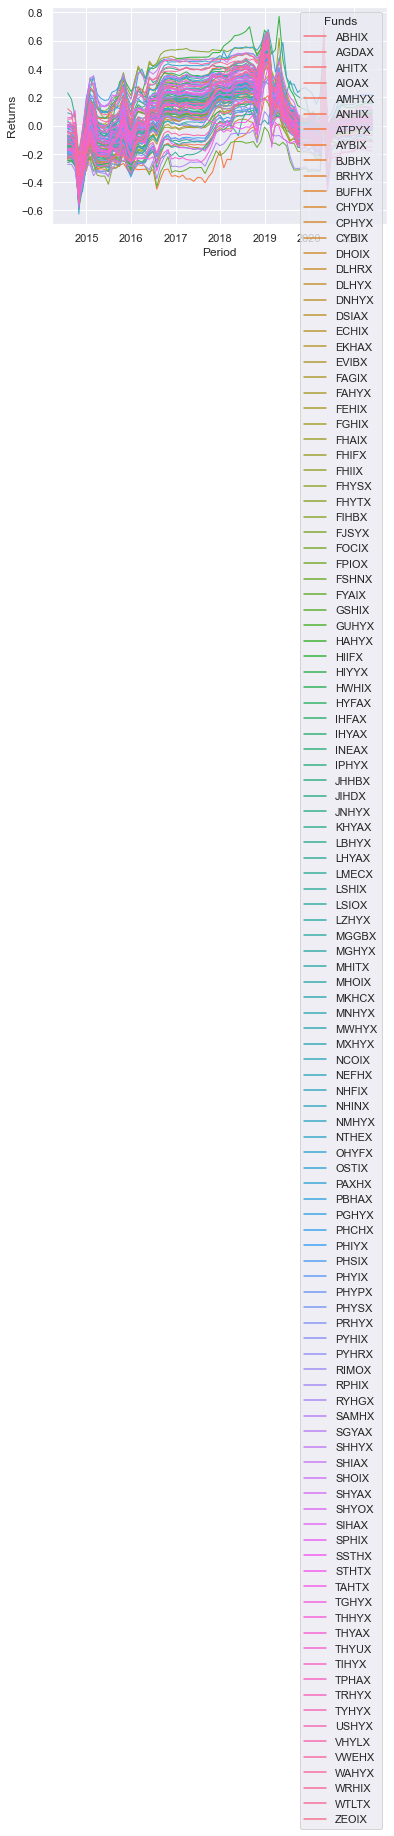

In [103]:
sns.lineplot(
    data=funds_AR_betas_2,
    x="Period", y = "Returns", hue="Funds"
    ,estimator=None, lw=1,
)

,Period,Funds,Returns
0,2014-07-31,_NT01,-0.120180
1,2014-08-31,_NT01,-0.119583
2,2014-09-30,_NT01,-0.143688
3,2014-10-31,_NT01,-0.456254
4,2014-11-30,_NT01,-0.240039
...,...,...,...
9706,2021-01-31,ZEOIX,-0.156210
9707,2021-02-28,ZEOIX,-0.152133
9708,2021-03-31,ZEOIX,-0.151164
9709,2021-04-30,ZEOIX,-0.151758
